In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
from functools import partial

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from src.config import Config
from src.episode import Episode
from src.episode_dataset import EpisodeDataset
from src.rl_data_record import RLDataRecord
from src.policy import Policy
from src.reward_model import RewardModel
from src.grpo_trainer import GRPOTrainer
from src.policy_model_utils import load_policy_model, save_policy_model, train_and_plot_policy, inference_and_plot_policy
from src.utils import get_color, normalize_min_max, to_device_collate, top_k_sampling
from src.episode_batch_reat_sampler import EpisodeBatchRepeatSampler

# Setup
---

In [2]:
config = Config()
reward_model = RewardModel(config=config)

# Datasets

train_dataset = EpisodeDataset(config=config, split="TRAIN")
print(f"train_dataset : {len(train_dataset)}")

test_dataset = EpisodeDataset(config=config, split="TEST")
print(f"test_dataset : {len(test_dataset)}")

eval_dataset = EpisodeDataset(config=config, split="EVAL")
print(f"eval_dataset : {len(eval_dataset)}")


# DataLoaders
def get_data_loader(
    dataset: EpisodeDataset, batch_size: int, group_size: int, repeats: int
):
    batch_repeat_sampler = EpisodeBatchRepeatSampler(
        dataset=dataset,
        batch_size=batch_size,
        group_size=group_size,
        repeats=repeats,
    )
    # print(
    #     f"batch_repeat_sampler: {len(batch_repeat_sampler)},  {list(batch_repeat_sampler)}"
    # )
    # print(
    #     f"batch ids: {[e.id for e in dataset.get_episods(batch_episode_idices=list(batch_repeat_sampler))]}"
    # )

    to_device_collate_configurable = partial(to_device_collate, config.device)
    dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size * group_size,
        sampler=batch_repeat_sampler,
        collate_fn=to_device_collate_configurable,
    )
    print(f"data loader: {dataset.split}, {len(dataloader)}")
    return dataloader


train_dataloader = get_data_loader(
    dataset=train_dataset,
    batch_size=config.train_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)
test_dataloader = get_data_loader(
    dataset=test_dataset,
    batch_size=config.test_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

eval_dataloader = get_data_loader(
    dataset=eval_dataset,
    batch_size=config.eval_batch_size,
    group_size=config.episode_group_size,
    repeats=config.episode_steps,
)

train_dataset : 20
test_dataset : 20
eval_dataset : 20
data loader: TRAIN, 50
data loader: TEST, 50
data loader: EVAL, 50


In [3]:
# for idx, batch_data in enumerate(train_dataloader):
#     batch_episode_idices = batch_data.get("episode_idx")
#     print(
#         f"idx: {idx}, batch_items: {len(batch_episode_idices)}, batch ids: {[e.id for e in train_dataset.get_episods(batch_episode_idices=batch_episode_idices)]}"
#     )

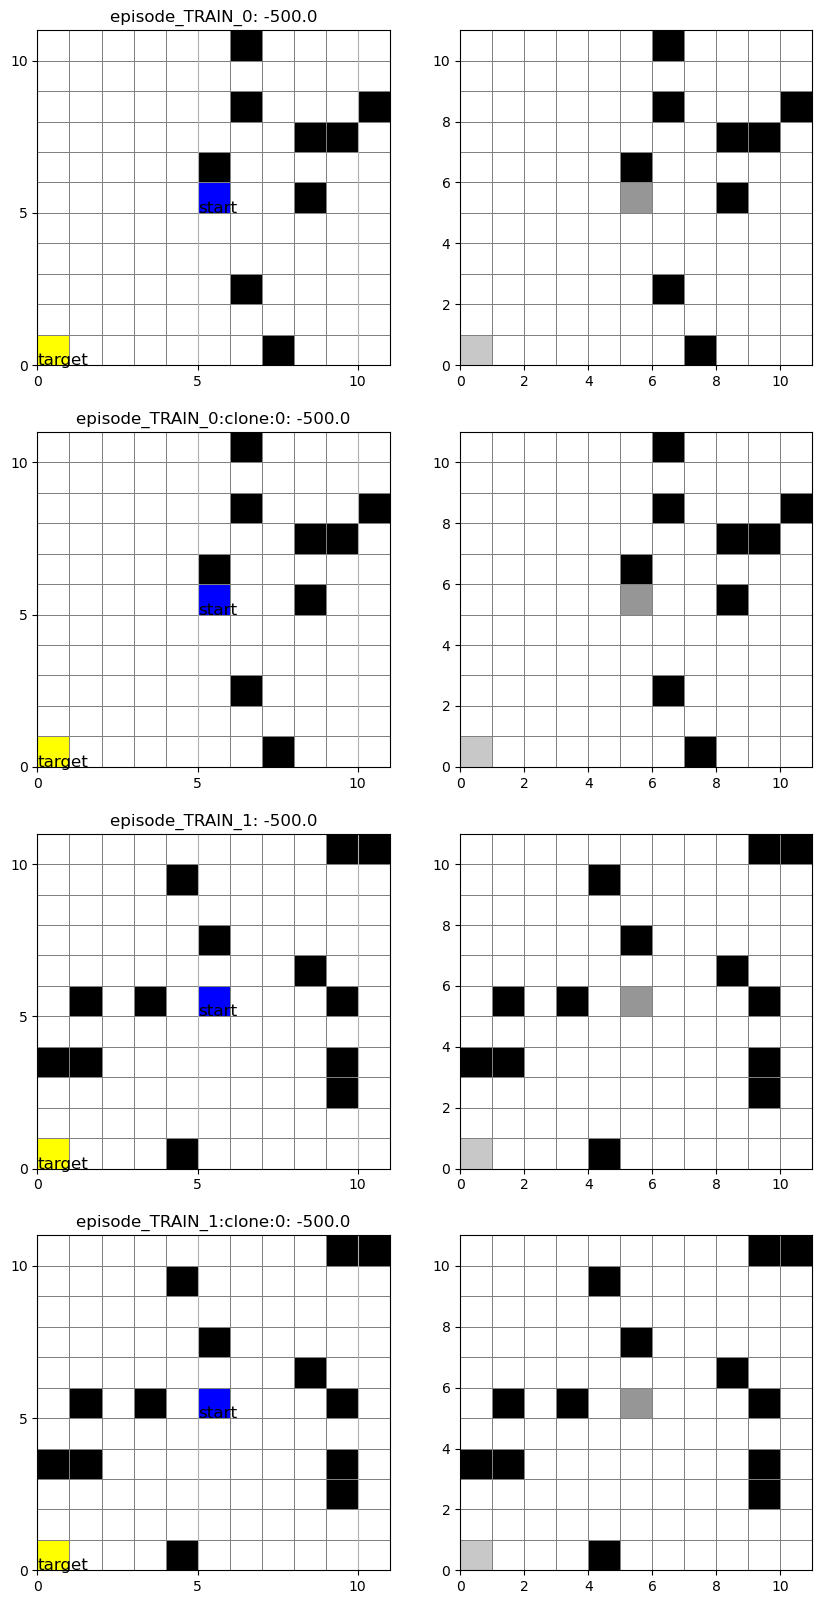

In [4]:
episode_samples = 4
fig, axes = plt.subplots(nrows=episode_samples, ncols=2, figsize=(10, 20))

for eidx in range(episode_samples):
    es = train_dataset.get_episode(eidx)

    es.viz(ax=axes[eidx][0], reward_model=reward_model)

    # Viz fov
    fov = es.fov(center_pos=es.agent.start_state.position())
    # print(f"fov: {fov.size()}, {fov}")
    # print(f"fov: {fov}")
    es.viz_fov(ax=axes[eidx][1])
plt.show()

step: 0, logits: tensor([[-450.8112, -148.7228,   91.2676, -360.7943, -184.0392, -591.5881,
         -567.9506, -493.3913,  -53.1823]]), logit_prob: tensor([[0.1879]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[2]]), state: tensor([4, 6]), action_history: [tensor(2)]
step: 1, logits: tensor([[-484.5953,   75.9140, -252.3327, -340.4766, -237.4800, -765.9193,
         -302.3547, -493.9207, -351.7995]]), logit_prob: tensor([[0.1784]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([3, 6]), action_history: [tensor(2), tensor(1)]
step: 2, logits: tensor([[-485.8827,   -9.5425, -248.0099, -308.5354, -279.4004, -659.0199,
         -237.8966, -588.1066, -338.3862]]), logit_prob: tensor([[0.1802]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[1]]), state: tensor([2, 6]), action_history: [tensor(2), tensor(1), tensor(1)]
step: 3, logits: tensor([[-250.6015,  159.0618, -257.9594, -328.4086, -257.6479, -586.6937,
         -186.6580, -512.1647, -355.4761]]), logit

/Users/chengbai/ml/cheng_git/rf_agent/src/policy.py:28: FutureWarning: `nn.init.kaiming_uniform` is now deprecated in favor of `nn.init.kaiming_uniform_`.
  layer.weight = nn.init.kaiming_uniform(layer.weight)


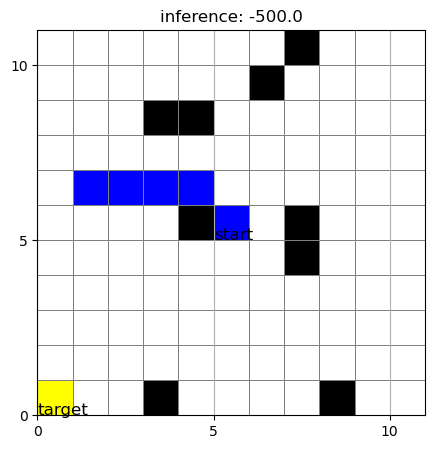

In [5]:
test_policy = Policy(config=config)
episode = inference_and_plot_policy(
    policy=test_policy, config=config, reward_model=reward_model, steps=5, debug=True
)
# episode.agent.action_history

In [6]:
# np.linalg.norm([8, 6], ord=1)
episode.reward(reward_model=reward_model)

tensor(-500.)

# Training Loop
---

In [7]:
policy = Policy(config=config)
reward_model = RewardModel(config=config)
trainer = GRPOTrainer(config=config, policy=policy, reward_model=reward_model)

step: 0, logits: tensor([[  94.1590, -220.4329, -609.5085, -204.4650,  111.1426, -516.7321,
         -213.1837, -310.6122, -124.5612]]), logit_prob: tensor([[0.1679]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[4]]), state: tensor([5, 5]), action_history: [tensor(4)]
step: 1, logits: tensor([[  94.1590, -220.4329, -609.5085, -204.4650,  111.1426, -516.7321,
         -213.1837, -310.6122, -124.5612]]), logit_prob: tensor([[0.1679]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[4]]), state: tensor([5, 5]), action_history: [tensor(4), tensor(4)]
step: 2, logits: tensor([[  94.1590, -220.4329, -609.5085, -204.4650,  111.1426, -516.7321,
         -213.1837, -310.6122, -124.5612]]), logit_prob: tensor([[0.1679]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[4]]), state: tensor([5, 5]), action_history: [tensor(4), tensor(4), tensor(4)]
step: 3, logits: tensor([[  94.1590, -220.4329, -609.5085, -204.4650,  111.1426, -516.7321,
         -213.1837, -310.6122, -124.5612]]), logit

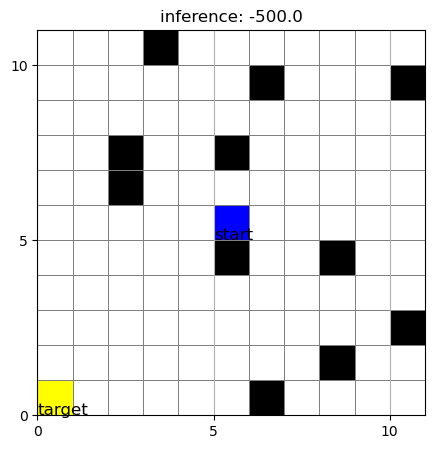

In [8]:
# Before tarin, policy behavior
episode = inference_and_plot_policy(
    policy=policy, config=config, reward_model=reward_model, steps=5, debug=True
)

In [20]:
# plt.ioff()
trainer.run(train_dataset=train_dataset, eval_dataset=eval_dataset, debug=False)
save_policy_model(policy=policy)

# plt.ion()

batch_repeat_sampler: [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 16, 17, 18, 19, 16, 17, 18, 19, 16, 17, 18, 19, 16, 17, 18, 19, 16, 17, 18, 19, 16, 17, 18, 19, 16, 17, 18, 19, 16, 17, 18, 19, 16, 17, 18, 19, 16, 17, 18, 19, 24, 25, 26, 27, 24, 25, 26, 27, 24, 25, 26, 27, 24, 25, 26, 27, 24, 25, 26, 27, 24, 25, 26, 27, 24, 25, 26, 27, 24, 25, 26, 27, 24, 25, 26, 27, 24, 25, 26, 27, 32, 33, 34, 35, 32, 33, 34, 35, 32, 33, 34, 35, 32, 33, 34, 35, 32, 33, 34, 35, 32, 33, 34, 35, 32, 33, 34, 35, 32, 33, 34, 35, 32, 33, 34, 35, 32, 33, 34, 35]
batch_repeat_sampler: [0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 11, 8, 9, 10, 

Epoch 2: 100%|██████████| 50/50 [00:00<00:00, 273.31it/s, split=TRAIN, step=10, batch_idx=49, should_run_optimization=1, current_batch_episode_idx=[32, 33, 34, 35]]


model_path: rf_model_policy_20250518225241.pt
Save policy model to: rf_model_policy_20250518225241.pt


step: 0, logits: tensor([[-9.6724e+09, -5.7030e+09, -4.8214e+09,  4.7034e+09,  9.2588e+09,
          1.8205e+09,  3.9870e+09,  6.2061e+09,  7.3817e+09]]), logit_prob: tensor([[0.1594]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[4]]), state: tensor([5, 5]), action_history: [tensor(4)]
step: 1, logits: tensor([[-9.6724e+09, -5.7030e+09, -4.8214e+09,  4.7034e+09,  9.2588e+09,
          1.8205e+09,  3.9870e+09,  6.2061e+09,  7.3817e+09]]), logit_prob: tensor([[0.1594]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[4]]), state: tensor([5, 5]), action_history: [tensor(4), tensor(4)]
step: 2, logits: tensor([[-9.6724e+09, -5.7030e+09, -4.8214e+09,  4.7034e+09,  9.2588e+09,
          1.8205e+09,  3.9870e+09,  6.2061e+09,  7.3817e+09]]), logit_prob: tensor([[0.1594]]), top_k_prob: tensor([[1.]]), action_idx: tensor([[4]]), state: tensor([5, 5]), action_history: [tensor(4), tensor(4), tensor(4)]
step: 3, logits: tensor([[-9.6724e+09, -5.7030e+09, -4.8214e+09,  4.7034e+09,  9.2588e+0

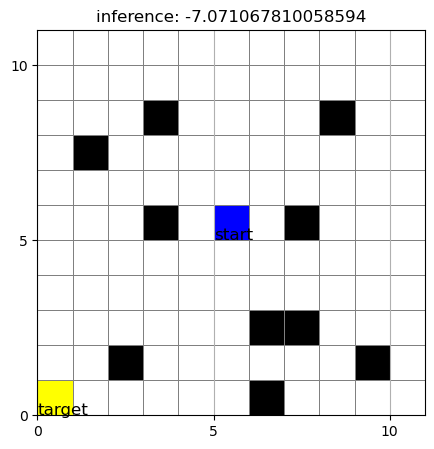

episode reward: -7.071067810058594


In [10]:
# post model training
episode = inference_and_plot_policy(
    policy=policy,
    config=config,
    reward_model=reward_model,
    steps=config.episode_steps,
    debug=True,
)
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

In [11]:
print(f"episode reward: {episode.reward(reward_model=reward_model)}")

episode reward: -7.071067810058594


# Evaluate the Model
----

In [12]:
# policy_model_path = (
#     "/Users/chengbai/ml/cheng_git/rf_agent/rf_model_policy_20250510230738_base.pt"
# )
# trained_policy = load_policy_model(config=config, policy_model_path=policy_model_path)
# assert trained_policy is not None

# episode = inference_and_plot_policy(
#     policy=trained_policy, config=config, reward_model=reward_model, steps=5, debug=True
# )

In [13]:
config.possible_actions

tensor([[-1, -1],
        [-1,  0],
        [-1,  1],
        [ 0, -1],
        [ 0,  0],
        [ 0,  1],
        [ 1, -1],
        [ 1,  0],
        [ 1,  1]])

In [14]:
config.possible_actions.shape[0] // 2

4

In [15]:
config.possible_actions[4]

tensor([0, 0])